## Took inspiration from Pytorch's tutorial
## https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [7]:
from os import path
import os
from torchvision import datasets
from torchvision.models import resnet50, ResNet50_Weights, vgg16_bn, VGG16_BN_Weights
from torch.utils.data import SubsetRandomSampler, DataLoader
import matplotlib.pyplot as plt
from random import randint
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import time
import copy
import sklearn
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

/Users/fluffyunicorn/Desktop/Deep Learning/ENV/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type=="cpu":
    print("No GPU available")
else:
    print("GPU available")

No GPU available


In [9]:
DS_STORE = ".DS_STORE"
DATASET_PATH = path.normpath(os.path.join("assets","dataset"))
if path.exists(path.join(DATASET_PATH, DS_STORE)):
    os.remove(path.join(DATASET_PATH, DS_STORE))
os.listdir(DATASET_PATH)

['no', 'yes']

In [10]:
IMAGES_PATH = []
for class_folder in os.listdir(DATASET_PATH):
    IMAGES_PATH.append(path.join(DATASET_PATH, class_folder))
print(IMAGES_PATH)

['assets/dataset/no', 'assets/dataset/yes']


In [11]:
list_of_classes = os.listdir(DATASET_PATH)
list_of_classes

['no', 'yes']

In [12]:
def apply_transformations(transformations):
    data = datasets.ImageFolder(root=DATASET_PATH, transform=transformations)
    return data

# 1. Resnet 50 Model

## 1.a Resnet 50 Model with Cross Entropy Loss, SGD Optimizer

In [13]:
# Using pretrained resnet 50 weights:
resnet_50_weights = ResNet50_Weights.IMAGENET1K_V2
resnet_50_model = resnet50(weights=resnet_50_weights)
resnet_50_transformations = resnet_50_weights.transforms()
resnet_50_transformations

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [14]:
data = apply_transformations(resnet_50_transformations)
data.samples[:5] ,data.classes[:5]

([('assets/dataset/no/1 no.jpeg', 0),
  ('assets/dataset/no/10 no.jpg', 0),
  ('assets/dataset/no/11 no.jpg', 0),
  ('assets/dataset/no/12 no.jpg', 0),
  ('assets/dataset/no/13 no.jpg', 0)],
 ['no', 'yes'])

## Random data from the dataset

Assets/Dataset/Yes/Y13.Jpg


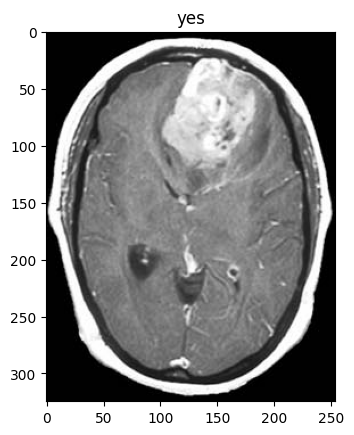

In [15]:
random_number = randint(0, len(data))
plt.imshow(plt.imread(data.samples[random_number][0]))
plt.title(list_of_classes[data.samples[random_number][1]])
print(data.samples[random_number][0].title())

## Dataloading

In [16]:

BATCH_SIZE = 32
train, val, test = torch.utils.data.random_split(data, [0.8, 0.1, 0.1])

data_loader = {}
data_loader["train"] = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
data_loader["val"] = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
data_loader["test"] = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)


In [17]:
resnet_50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
for param in resnet_50_model.parameters():
    print(param.requires_grad)
    break

True


In [19]:
# Turning off learning on all layers
for param in resnet_50_model.parameters():
    param.requires_grad = False

In [20]:
# Enabling/ unfreezing last fully connected layer
print("Current FC layer:", resnet_50_model.fc)
resnet_50_model.fc = nn.Linear(resnet_50_model.fc.in_features, len(list_of_classes))
print("Model with new FC layer:", resnet_50_model.fc)

Current FC layer: Linear(in_features=2048, out_features=1000, bias=True)
Model with new FC layer: Linear(in_features=2048, out_features=2, bias=True)


## Hyperparameters

In [21]:

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(resnet_50_model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Training 

In [22]:
dataset_sizes = {"train": len(train.indices) , "val":len(val.indices)}
dataset_sizes, {"test":len(test.indices)}

({'train': 203, 'val': 25}, {'test': 25})

In [23]:
loss_track = {"train":[], "val":[]}
acc_track = {"train":[], "val":[]}

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                # print(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase=="train":
                acc_track["train"].append(epoch_acc)
                loss_track["train"].append(epoch_loss)
                
            elif phase=="val":
                acc_track["val"].append(epoch_acc)
                loss_track["val"].append(epoch_loss)
                
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), os.path.join(MODEL_PATH,str(epoch)))


        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Training 

In [18]:
%%time
MODEL_PATH = "models/Resnet_50_SGD"
if not os.path.isdir(MODEL_PATH):
    os.makedirs(MODEL_PATH)

model_conv = train_model(resnet_50_model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
torch.save(model_conv.state_dict(), os.path.join(MODEL_PATH, "top"))

Epoch 0/24
----------
train Loss: 0.6772 Acc: 0.6355
val Loss: 0.6846 Acc: 0.6000

Epoch 1/24
----------
train Loss: 0.6563 Acc: 0.6256
val Loss: 0.6327 Acc: 0.7600

Epoch 2/24
----------
train Loss: 0.6330 Acc: 0.6158
val Loss: 0.5886 Acc: 0.8000

Epoch 3/24
----------
train Loss: 0.6186 Acc: 0.6158
val Loss: 0.5586 Acc: 0.8000

Epoch 4/24
----------
train Loss: 0.5976 Acc: 0.6502
val Loss: 0.5432 Acc: 0.8000

Epoch 5/24
----------
train Loss: 0.5762 Acc: 0.6601
val Loss: 0.5363 Acc: 0.8000

Epoch 6/24
----------
train Loss: 0.5642 Acc: 0.7340
val Loss: 0.5219 Acc: 0.8400

Epoch 7/24
----------
train Loss: 0.5484 Acc: 0.7537
val Loss: 0.5108 Acc: 0.8400

Epoch 8/24
----------
train Loss: 0.5493 Acc: 0.7586
val Loss: 0.5222 Acc: 0.8400

Epoch 9/24
----------
train Loss: 0.5512 Acc: 0.7537
val Loss: 0.5252 Acc: 0.8800

Epoch 10/24
----------
train Loss: 0.5443 Acc: 0.7635
val Loss: 0.5262 Acc: 0.8800

Epoch 11/24
----------
train Loss: 0.5375 Acc: 0.7488
val Loss: 0.5258 Acc: 0.8800

Ep

In [19]:
print("Loss Track", loss_track, "\n")
print("Acc Track", acc_track)

Loss Track {'train': [0.6772136488571543, 0.6562570430375085, 0.6330477184262769, 0.6185714032849655, 0.5976356661378457, 0.576177808745154, 0.5641876779166348, 0.5484239012736992, 0.5492802356264274, 0.551223908445518, 0.5442816720807494, 0.5375131914768313, 0.544635778283838, 0.5364198396945822, 0.5368058822425128, 0.5402779405927424, 0.539573575475533, 0.5351478369365185, 0.5476109414852312, 0.5343475603117731, 0.5372651756690641, 0.5385055025222854, 0.5418521582786673, 0.5337598773058999, 0.5406763647577445], 'val': [0.6846020221710205, 0.6327110528945923, 0.5885722637176514, 0.5586276054382324, 0.5432393550872803, 0.5363123416900635, 0.5218760371208191, 0.5107570886611938, 0.5222351551055908, 0.5252147316932678, 0.526210367679596, 0.5257619023323059, 0.5168643593788147, 0.5081185102462769, 0.5177004337310791, 0.5153253674507141, 0.5246116518974304, 0.5121169090270996, 0.504671037197113, 0.5086207985877991, 0.5070217251777649, 0.50852370262146, 0.5068775415420532, 0.504040002822876

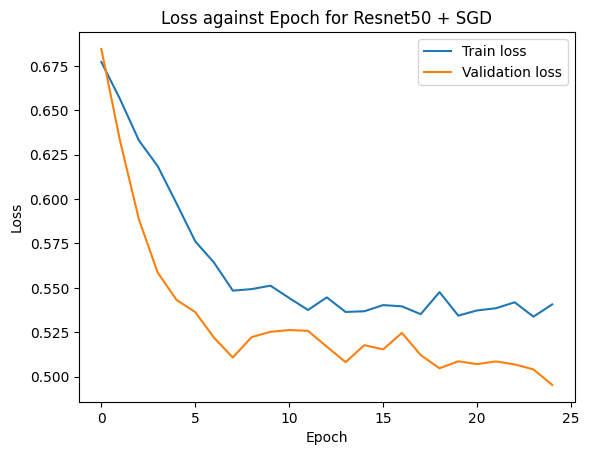

In [20]:
plt.plot(loss_track["train"], label="Train loss")
plt.plot(loss_track["val"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss against Epoch for Resnet50 + SGD")
plt.show()

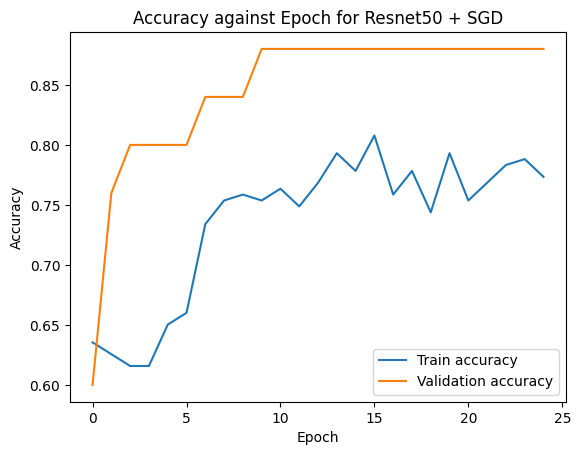

In [21]:
plt.plot(acc_track["train"], label="Train accuracy")
plt.plot(acc_track["val"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy against Epoch for Resnet50 + SGD")
plt.show()

## Inference

Text(0.5, 1.0, 'Confusion Matrix for Resnet 50 with SGD')

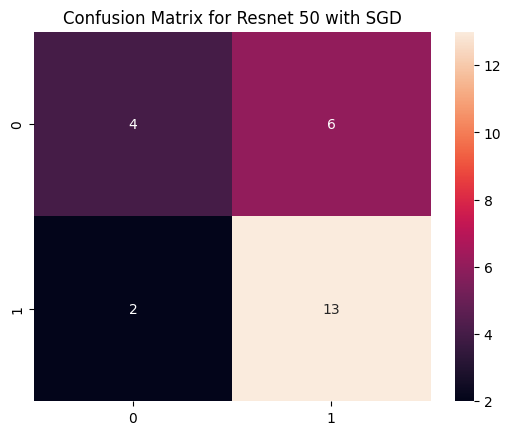

In [24]:
# Switching to inference mode
MODEL_PATH = "models/Resnet_50_SGD"

PATH = os.path.join(MODEL_PATH, "top")
resnet_50_model.load_state_dict(torch.load(PATH))
# Uncomment the above line if you want to load an existing model
resnet_50_model.eval()

y_test = np.array([], dtype=np.int64)
y_pred = np.array([], dtype=np.int64)
for image, label in data_loader["test"]:
    y_test = np.append(y_test, label.numpy())
    
    output = resnet_50_model(image)
    pred_labels = torch.max(output, 1)[1]
    
    y_pred = np.append(y_pred, pred_labels.numpy())
    
    
coff_matrix = confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(coff_matrix, annot=True)
plt.title("Confusion Matrix for Resnet 50 with SGD")

In [25]:
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
print("Accuracy of the resnet 50 model with SGD " \
      "and Cross Entropy Loss is: {}%".format(acc*100))

Accuracy of the resnet 50 model with SGD and Cross Entropy Loss is: 68.0%


## 1.b Resnet 50 Model with Cross Entropy Loss, Adam Optimizer

In [26]:
resnet_50_weights = ResNet50_Weights.IMAGENET1K_V2
resnet_50_model = resnet50(weights=resnet_50_weights)

# Turning off learning on all layers
for param in resnet_50_model.parameters():
    param.requires_grad = False
    
# Enabling/ unfreezing last fully connected layer
print("Current FC layer:", resnet_50_model.fc)
resnet_50_model.fc = nn.Linear(resnet_50_model.fc.in_features, len(list_of_classes))
print("Model with new FC layer:", resnet_50_model.fc)

Current FC layer: Linear(in_features=2048, out_features=1000, bias=True)
Model with new FC layer: Linear(in_features=2048, out_features=2, bias=True)


In [27]:

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(resnet_50_model.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [28]:
%%time
MODEL_PATH = "models/Resnet_50_Adam"
if not os.path.isdir(MODEL_PATH):
    os.makedirs(MODEL_PATH)

loss_track = {"train":[], "val":[]}
acc_track = {"train":[], "val":[]}

model_conv = train_model(resnet_50_model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
torch.save(model_conv.state_dict(), os.path.join(MODEL_PATH, "top"))

Epoch 0/24
----------
train Loss: 0.6489 Acc: 0.5714
val Loss: 0.5814 Acc: 0.7600

Epoch 1/24
----------
train Loss: 0.5541 Acc: 0.6995
val Loss: 0.5154 Acc: 0.8800

Epoch 2/24
----------
train Loss: 0.4873 Acc: 0.7734
val Loss: 0.5005 Acc: 0.8400

Epoch 3/24
----------
train Loss: 0.4508 Acc: 0.8424
val Loss: 0.5016 Acc: 0.8400

Epoch 4/24
----------
train Loss: 0.4022 Acc: 0.9163
val Loss: 0.4293 Acc: 0.8400

Epoch 5/24
----------
train Loss: 0.3662 Acc: 0.8621
val Loss: 0.3815 Acc: 0.9600

Epoch 6/24
----------
train Loss: 0.3350 Acc: 0.9064
val Loss: 0.3608 Acc: 0.9200

Epoch 7/24
----------
train Loss: 0.3295 Acc: 0.9163
val Loss: 0.3313 Acc: 0.9200

Epoch 8/24
----------
train Loss: 0.3147 Acc: 0.9212
val Loss: 0.3227 Acc: 0.9200

Epoch 9/24
----------
train Loss: 0.3110 Acc: 0.9015
val Loss: 0.3194 Acc: 0.9200

Epoch 10/24
----------
train Loss: 0.3407 Acc: 0.8916
val Loss: 0.3147 Acc: 0.9200

Epoch 11/24
----------
train Loss: 0.3046 Acc: 0.9212
val Loss: 0.3102 Acc: 0.9200

Ep

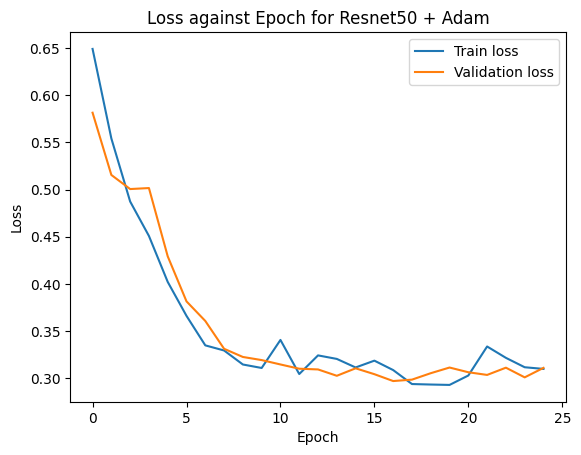

In [29]:
plt.plot(loss_track["train"], label="Train loss")
plt.plot(loss_track["val"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss against Epoch for Resnet50 + Adam")
plt.show()

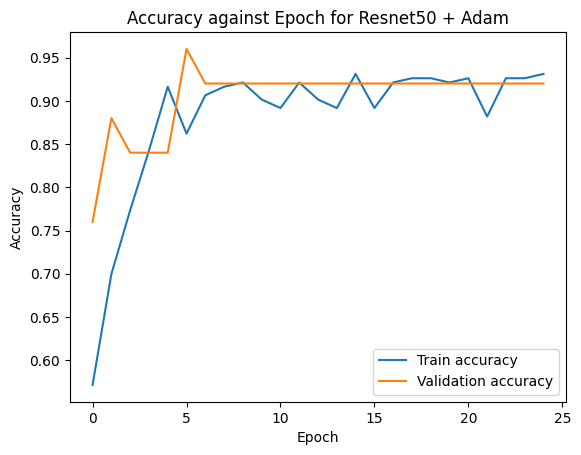

In [30]:
plt.plot(acc_track["train"], label="Train accuracy")
plt.plot(acc_track["val"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy against Epoch for Resnet50 + Adam")
plt.show()

## Inference

Text(0.5, 1.0, 'Confusion Matrix for Resnet 50 with Adam')

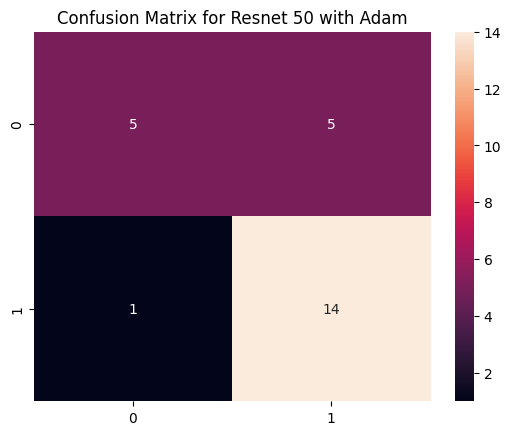

In [31]:
# Switching to inference mode
MODEL_PATH = "models/Resnet_50_Adam"
PATH = os.path.join(MODEL_PATH, "top")
resnet_50_model.load_state_dict(torch.load(PATH))
# Uncomment the above line if you want to load an existing model
resnet_50_model.eval()

y_test = np.array([], dtype=np.int64)
y_pred = np.array([], dtype=np.int64)
for image, label in data_loader["test"]:
    y_test = np.append(y_test, label.numpy())
    
    output = resnet_50_model(image)
    pred_labels = torch.max(output, 1)[1]
    
    y_pred = np.append(y_pred, pred_labels.numpy())
    
    
coff_matrix = confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(coff_matrix, annot=True)
plt.title("Confusion Matrix for Resnet 50 with Adam")

In [32]:
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
print("Accuracy of the resnet 50 model with Adam " \
      "and Cross Entropy Loss is: {}%".format(acc*100))

Accuracy of the resnet 50 model with Adam and Cross Entropy Loss is: 76.0%


## 1.c Resnet 50 Model with Cross Entropy Loss, Adam Optimizer + LR adjusted

In [31]:
resnet_50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
resnet_50_weights = ResNet50_Weights.IMAGENET1K_V2
resnet_50_model = resnet50(weights=resnet_50_weights)

# Turning off learning on all layers
for param in resnet_50_model.parameters():
    param.requires_grad = False
    
# Enabling/ unfreezing last fully connected layer
print("Current FC layer:", resnet_50_model.fc)
resnet_50_model.fc = nn.Linear(resnet_50_model.fc.in_features, len(list_of_classes))
print("Model with new FC layer:", resnet_50_model.fc)

Current FC layer: Linear(in_features=2048, out_features=1000, bias=True)
Model with new FC layer: Linear(in_features=2048, out_features=2, bias=True)


In [34]:

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(resnet_50_model.fc.parameters(), lr=0.003)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [35]:
%%time
MODEL_PATH = "models/Resnet_50_Adam_LR"
if not os.path.isdir(MODEL_PATH):
    os.makedirs(MODEL_PATH)

loss_track = {"train":[], "val":[]}
acc_track = {"train":[], "val":[]}
    
model_conv = train_model(resnet_50_model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)
torch.save(model_conv.state_dict(), os.path.join(MODEL_PATH, "top"))

Epoch 0/49
----------
train Loss: 0.6924 Acc: 0.5961
val Loss: 0.7230 Acc: 0.4400

Epoch 1/49
----------
train Loss: 0.4849 Acc: 0.8571
val Loss: 0.7126 Acc: 0.4400

Epoch 2/49
----------
train Loss: 0.3631 Acc: 0.8916
val Loss: 0.3599 Acc: 0.9200

Epoch 3/49
----------
train Loss: 0.3206 Acc: 0.8522
val Loss: 0.3316 Acc: 0.9200

Epoch 4/49
----------
train Loss: 0.2521 Acc: 0.9310
val Loss: 0.3759 Acc: 0.9200

Epoch 5/49
----------
train Loss: 0.2218 Acc: 0.9507
val Loss: 0.2632 Acc: 0.9600

Epoch 6/49
----------
train Loss: 0.1933 Acc: 0.9704
val Loss: 0.2379 Acc: 0.9600

Epoch 7/49
----------
train Loss: 0.1870 Acc: 0.9557
val Loss: 0.2174 Acc: 0.9600

Epoch 8/49
----------
train Loss: 0.1850 Acc: 0.9557
val Loss: 0.2147 Acc: 0.9600

Epoch 9/49
----------
train Loss: 0.1881 Acc: 0.9557
val Loss: 0.2469 Acc: 0.9600

Epoch 10/49
----------
train Loss: 0.1693 Acc: 0.9507
val Loss: 0.2541 Acc: 0.8800

Epoch 11/49
----------
train Loss: 0.1734 Acc: 0.9606
val Loss: 0.2584 Acc: 0.8800

Ep

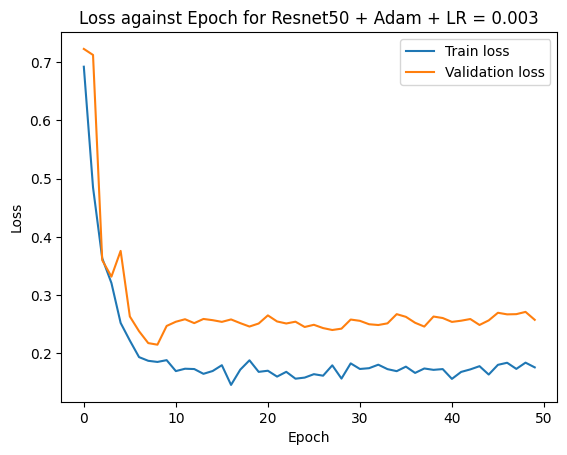

In [36]:
plt.plot(loss_track["train"], label="Train loss")
plt.plot(loss_track["val"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss against Epoch for Resnet50 + Adam + LR = 0.003")
plt.show()

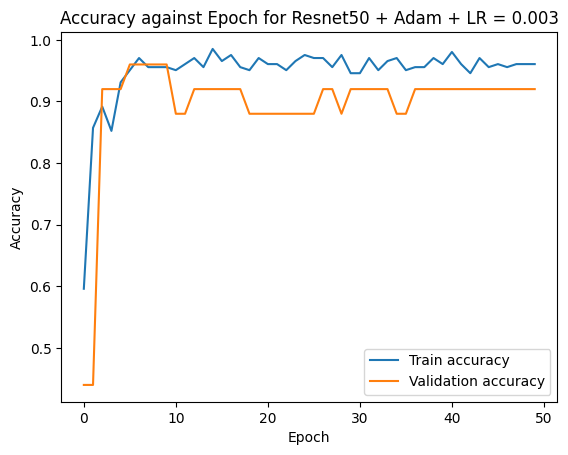

In [37]:
plt.plot(acc_track["train"], label="Train accuracy")
plt.plot(acc_track["val"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy against Epoch for Resnet50 + Adam + LR = 0.003")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix for Resnet 50 with Adam + LR=0.003')

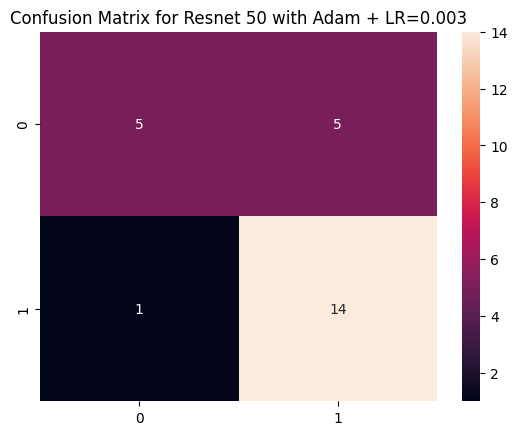

In [38]:
# Switching to inference mode
MODEL_PATH = "models/Resnet_50_Adam_LR"
PATH = os.path.join(MODEL_PATH, "top")
resnet_50_model.load_state_dict(torch.load(PATH))
# Uncomment the above line if you want to load an existing model
resnet_50_model.eval()

y_test = np.array([], dtype=np.int64)
y_pred = np.array([], dtype=np.int64)
for image, label in data_loader["test"]:
    y_test = np.append(y_test, label.numpy())
    
    output = resnet_50_model(image)
    pred_labels = torch.max(output, 1)[1]
    
    y_pred = np.append(y_pred, pred_labels.numpy())
    
    
coff_matrix = confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(coff_matrix, annot=True)
plt.title("Confusion Matrix for Resnet 50 with Adam + LR=0.003")

In [39]:
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
print("Accuracy of the Resnet 50 model with Adam + LR=0.003 " \
      "and Cross Entropy Loss is: {}%".format(acc*100))

Accuracy of the Resnet 50 model with Adam + LR=0.003 and Cross Entropy Loss is: 76.0%


<b>---------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## 2.a VGG16 Model with SGD

In [40]:
# Using pretrained resnet 50 weights:
vgg_bn_16_weights = VGG16_BN_Weights.IMAGENET1K_V1
vgg16_bn_model = vgg16_bn(weights=vgg_bn_16_weights)
vgg16_bn_transformations = vgg_bn_16_weights.transforms()
vgg16_bn_transformations

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [41]:
data = apply_transformations(vgg16_bn_transformations)
data.samples[:5] ,data.classes[:5]

([('assets/dataset/no/1 no.jpeg', 0),
  ('assets/dataset/no/10 no.jpg', 0),
  ('assets/dataset/no/11 no.jpg', 0),
  ('assets/dataset/no/12 no.jpg', 0),
  ('assets/dataset/no/13 no.jpg', 0)],
 ['no', 'yes'])

Assets/Dataset/No/No 95.Jpg


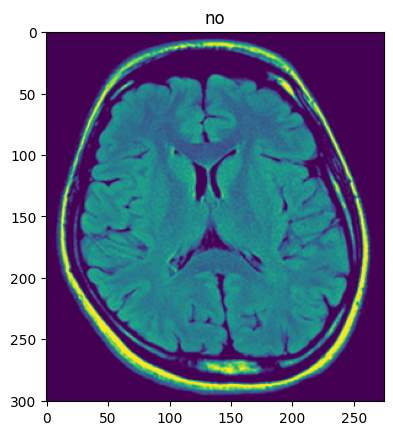

In [42]:
random_number = randint(0, len(data))
plt.imshow(plt.imread(data.samples[random_number][0]))
plt.title(list_of_classes[data.samples[random_number][1]])
print(data.samples[random_number][0].title())

In [43]:

BATCH_SIZE = 32
train, val, test = torch.utils.data.random_split(data, [0.8, 0.1, 0.1])

data_loader = {}
data_loader["train"] = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
data_loader["val"] = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
data_loader["test"] = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)


In [43]:
vgg16_bn_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [44]:
# Turning off learning on all layers
for param in vgg16_bn_model.parameters():
    param.requires_grad = False

In [45]:
vgg16_bn_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [46]:
# Enabling/ unfreezing last fully connected layer
print("Current FC layers:", vgg16_bn_model.classifier)
vgg16_bn_model.classifier[6] = nn.Linear(vgg16_bn_model.classifier[6].in_features, len(list_of_classes))
print("Model with new FC layer:", vgg16_bn_model.classifier)

Current FC layers: Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Model with new FC layer: Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [47]:
# Unfreezing all the classifier layers
for param in vgg16_bn_model.classifier.parameters():
    param.requires_grad = True

In [48]:
# Sanity Check
for param in vgg16_bn_model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [49]:

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(vgg16_bn_model.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [50]:
%%time
MODEL_PATH = "models/VGG_16_SGD"
if not os.path.isdir(MODEL_PATH):
    os.makedirs(MODEL_PATH)


loss_track = {"train":[], "val":[]}
acc_track = {"train":[], "val":[]}

model_conv = train_model(vgg16_bn_model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
torch.save(model_conv.state_dict(), os.path.join(MODEL_PATH, "top"))

Epoch 0/24
----------
train Loss: 0.6734 Acc: 0.5369
val Loss: 0.5765 Acc: 0.6400

Epoch 1/24
----------
train Loss: 0.5405 Acc: 0.7044
val Loss: 0.4250 Acc: 0.9200

Epoch 2/24
----------
train Loss: 0.4220 Acc: 0.8276
val Loss: 0.3306 Acc: 0.9600

Epoch 3/24
----------
train Loss: 0.3605 Acc: 0.8374
val Loss: 0.2859 Acc: 0.9200

Epoch 4/24
----------
train Loss: 0.3040 Acc: 0.8916
val Loss: 0.2709 Acc: 0.8800

Epoch 5/24
----------
train Loss: 0.2677 Acc: 0.8818
val Loss: 0.2625 Acc: 0.9200

Epoch 6/24
----------
train Loss: 0.2247 Acc: 0.9113
val Loss: 0.2777 Acc: 0.8800

Epoch 7/24
----------
train Loss: 0.2017 Acc: 0.9360
val Loss: 0.2827 Acc: 0.8400

Epoch 8/24
----------
train Loss: 0.1999 Acc: 0.9409
val Loss: 0.2919 Acc: 0.8400

Epoch 9/24
----------
train Loss: 0.1923 Acc: 0.9507
val Loss: 0.3002 Acc: 0.8400

Epoch 10/24
----------
train Loss: 0.1808 Acc: 0.9360
val Loss: 0.3005 Acc: 0.8400

Epoch 11/24
----------
train Loss: 0.1916 Acc: 0.9360
val Loss: 0.3056 Acc: 0.8400

Ep

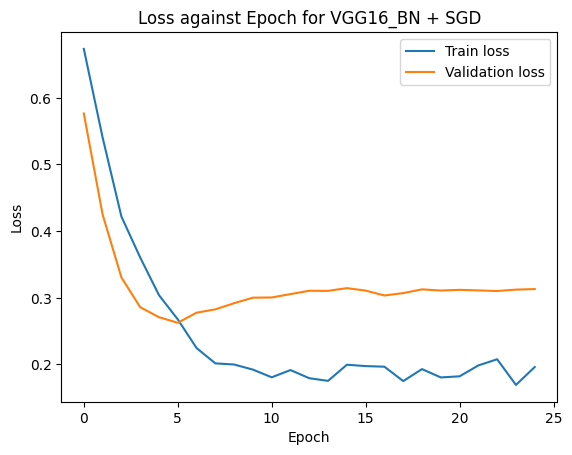

In [51]:
plt.plot(loss_track["train"], label="Train loss")
plt.plot(loss_track["val"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss against Epoch for VGG16_BN + SGD")
plt.show()

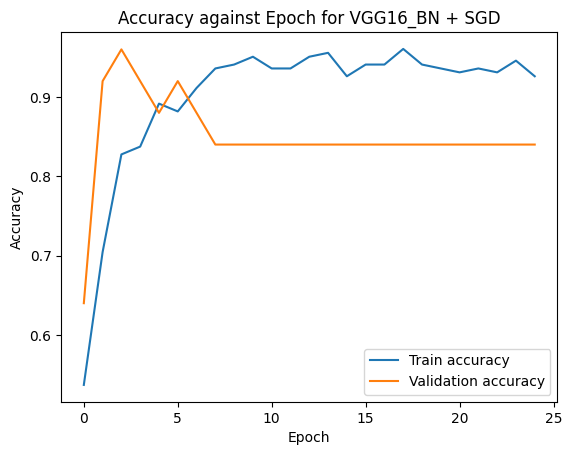

In [52]:
plt.plot(acc_track["train"], label="Train accuracy")
plt.plot(acc_track["val"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy against Epoch for VGG16_BN + SGD")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix for VGG16_BN with SGD')

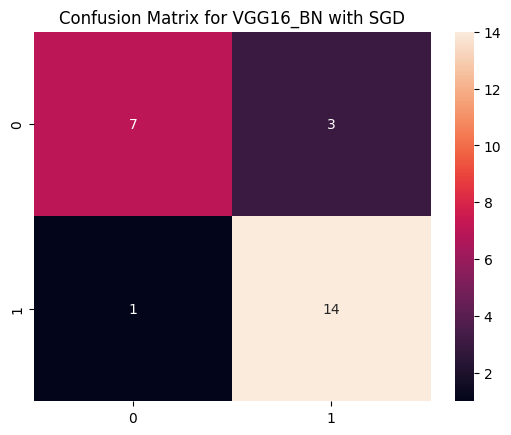

In [53]:
# Switching to inference mode
MODEL_PATH = "models/VGG_16_SGD"
PATH = os.path.join(MODEL_PATH, "top")
vgg16_bn_model.load_state_dict(torch.load(PATH))
# Uncomment the above line if you want to load an existing model
vgg16_bn_model.eval()

y_test = np.array([], dtype=np.int64)
y_pred = np.array([], dtype=np.int64)
for image, label in data_loader["test"]:
    y_test = np.append(y_test, label.numpy())
    
    output = vgg16_bn_model(image)
    pred_labels = torch.max(output, 1)[1]
    
    y_pred = np.append(y_pred, pred_labels.numpy())
    
    
coff_matrix = confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(coff_matrix, annot=True)
plt.title("Confusion Matrix for VGG16_BN with SGD")

In [54]:
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
print("Accuracy of the vgg16_bn model with SGD " \
      "and Cross Entropy Loss is: {}%".format(acc*100))

Accuracy of the vgg16_bn model with SGD and Cross Entropy Loss is: 84.0%


## 2.b VGG16 Model with Adam optimizer

In [55]:
# Using pretrained resnet 50 weights:
vgg_bn_16_weights = VGG16_BN_Weights.IMAGENET1K_V1
vgg16_bn_model = vgg16_bn(weights=vgg_bn_16_weights)
vgg16_bn_transformations = vgg_bn_16_weights.transforms()
vgg16_bn_transformations

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [56]:
# Turning off learning on all layers
for param in vgg16_bn_model.parameters():
    param.requires_grad = False

In [57]:
vgg16_bn_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [58]:
# Enabling/ unfreezing last fully connected layer
print("Current FC layers:", vgg16_bn_model.classifier)
vgg16_bn_model.classifier[6] = nn.Linear(vgg16_bn_model.classifier[6].in_features, len(list_of_classes))
print("Model with new FC layer:", vgg16_bn_model.classifier)

Current FC layers: Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Model with new FC layer: Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [59]:
# Unfreezing all the classifier layers
for param in vgg16_bn_model.classifier.parameters():
    param.requires_grad = True

In [60]:
# Sanity Check
for param in vgg16_bn_model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [61]:

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(vgg16_bn_model.classifier.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [62]:
%%time
MODEL_PATH = "models/VGG_16_Adam"
if not os.path.isdir(MODEL_PATH):
    os.makedirs(MODEL_PATH)


loss_track = {"train":[], "val":[]}
acc_track = {"train":[], "val":[]}


model_conv = train_model(vgg16_bn_model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
torch.save(model_conv.state_dict(), os.path.join(MODEL_PATH, "top"))

Epoch 0/24
----------
train Loss: 1.2727 Acc: 0.6404
val Loss: 0.4118 Acc: 0.6800

Epoch 1/24
----------
train Loss: 0.3827 Acc: 0.8227
val Loss: 0.4519 Acc: 0.9200

Epoch 2/24
----------
train Loss: 0.2262 Acc: 0.9064
val Loss: 0.2658 Acc: 0.8400

Epoch 3/24
----------
train Loss: 0.0788 Acc: 0.9754
val Loss: 0.4762 Acc: 0.8400

Epoch 4/24
----------
train Loss: 0.0619 Acc: 0.9852
val Loss: 1.0813 Acc: 0.9200

Epoch 5/24
----------
train Loss: 0.0850 Acc: 0.9803
val Loss: 1.8526 Acc: 0.7200

Epoch 6/24
----------
train Loss: 0.0863 Acc: 0.9852
val Loss: 1.4935 Acc: 0.8400

Epoch 7/24
----------
train Loss: 0.0156 Acc: 0.9951
val Loss: 1.5697 Acc: 0.8400

Epoch 8/24
----------
train Loss: 0.1169 Acc: 0.9754
val Loss: 1.6499 Acc: 0.8400

Epoch 9/24
----------
train Loss: 0.0121 Acc: 0.9951
val Loss: 1.6610 Acc: 0.8400

Epoch 10/24
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 1.6584 Acc: 0.8400

Epoch 11/24
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 1.6721 Acc: 0.8400

Ep

Text(0.5, 1.0, 'Confusion Matrix for VGG16_BN with Adam')

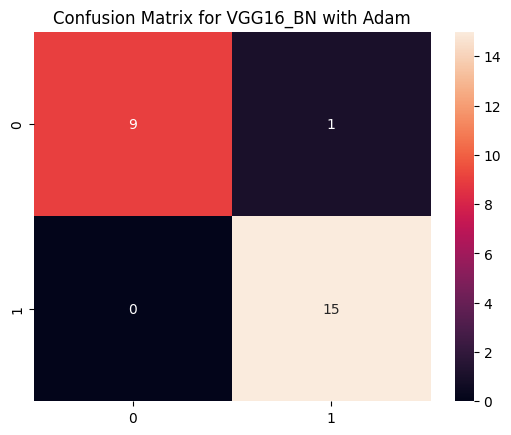

In [71]:
# Switching to inference mode
MODEL_PATH = "models/VGG_16_Adam"
PATH = os.path.join(MODEL_PATH, "top")
vgg16_bn_model.load_state_dict(torch.load(PATH))
# Uncomment the above line if you want to load an existing model
vgg16_bn_model.eval()

y_test = np.array([], dtype=np.int64)
y_pred = np.array([], dtype=np.int64)
for image, label in data_loader["test"]:
    y_test = np.append(y_test, label.numpy())
    
    output = vgg16_bn_model(image)
    pred_labels = torch.max(output, 1)[1]
    
    y_pred = np.append(y_pred, pred_labels.numpy())
    
    
coff_matrix = confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(coff_matrix, annot=True)
plt.title("Confusion Matrix for VGG16_BN with Adam")

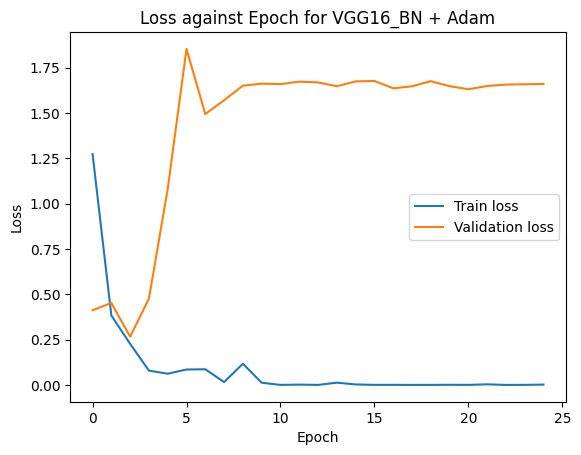

In [72]:
plt.plot(loss_track["train"], label="Train loss")
plt.plot(loss_track["val"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss against Epoch for VGG16_BN + Adam")
plt.show()

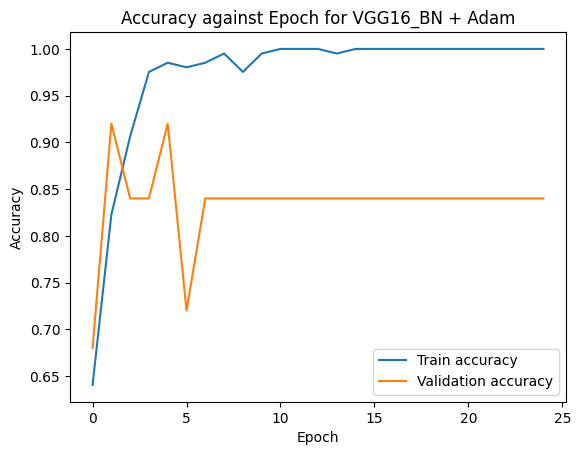

In [73]:
plt.plot(acc_track["train"], label="Train accuracy")
plt.plot(acc_track["val"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy against Epoch for VGG16_BN + Adam")
plt.show()

In [74]:
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
print("Accuracy of the VGG16_BN model with Adam" \
      " and Cross Entropy Loss is: {}%".format(acc*100))

Accuracy of the VGG16_BN model with Adam and Cross Entropy Loss is: 96.0%
